# Version information

In [16]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: July 03, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


# Analytical Air-Gap Surface Force Transfer
모터에서 자기력을 계산하는 주요 방법 중 하나는 Maxwell Stress Tensor(MST)를 기반으로 하는 AGSF(Air-gap Surface Force) 방법입니다. 이 방법은 Air-gap에서 자속밀도분포를 이용하여 등가 자기 압력을 계산하는 것입니다. 그러나 이 개념을 사용할때 고려해야하는 점은 아래와 같습니다.

- 정자기 유한 요소해는 공극 중앙에서 최소의 수치 오차를 갖는다.
- 기계 연동 해석시 MST에 의한 Force는 고정자 Bore 반경(치부위)에 적용하기 때문에 이론적으로 고정자 Bore 반경에서 Force를 적용해야 더 정확해야 합니다.

이 문제를 해결하기 위해 공극 중앙에서의 AGSF 계산값으로부터 고정자 보어 반경에서 AGSF로 Transfer 하는는 방법이 제안됩니다. [1]



## Import Pyleecan modules and machine definition

In [17]:
from os.path import join
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Functions.load import load 
from pyleecan.definitions import DATA_DIR
from pyleecan.Classes._FEMMHandler import _FEMMHandler


In [18]:
# %matplotlib notebook
# Load machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
# Toyota_Prius.plot()
# femm = _FEMMHandler()
# femm.openfemm(0)
# femm.opendocument('D:/NGV/DN8/DN8.fem')

## Simulation definition

In [19]:
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Functions.load import load
# from pyleecan.definitions import DATA_DIR
import math

# 시뮬레이션 정의 
simu = Simu1(name="Toyota_Prius_AGSF_Transfer", machine=Toyota_Prius)
# Simu_DIR='D:/NGV/DN8'
# DN8=load(join(Simu_DIR, "DN8_tota_anti.json"))
# simu = Simu1(name="DN8", machine=DN8)
# 해석 운전점 (id/iq,rpm) 정의

rpm=1000
I0_rms = 250/math.sqrt(2) # Maximum current [Arms]
Phi0 = 140*pi/180  
Id_ref = (I0_rms*exp(1j*Phi0)).real  # 해당 Id/Iq 환산
Iq_ref = (I0_rms*exp(1j*Phi0)).imag
# simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# 입력값 정의 
simu.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0,N0=rpm),
    # Na_tot=5 * 2 ** 8, Nt_tot=2,
    Na_tot=2 ** 16, # angle    
    Nt_tot=2 ** 8, #Time
    Ir=None,
)

# 해석 주기성 및 조건 셋팅

simu.elec = None
simu.mag = MagFEMM(
    is_periodicity_a=True,
    is_periodicity_t=True,
    nb_worker=8,
    # is_sliding_band=False,
    Kmesh_fineness=4,
    type_BH_rotor=0,
    type_BH_stator=0
)
simu.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True
    )
simu.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing



# # Run simulations


In [20]:
out = simu.run()


[12:06:44] Starting running simulation Toyota_Prius_AGSF_Transfer (machine=Toyota_Prius)
[12:06:44] Starting Magnetic module
[12:06:45] Solving time step 1 / 32 in FEMM
[12:06:45] Solving time step 9 / 32 in FEMM
[12:06:45] Solving time step 17 / 32 in FEMM
[12:06:45] Solving time step 21 / 32 in FEMM
[12:06:45] Solving time step 25 / 32 in FEMM
[12:06:46] Solving time step 5 / 32 in FEMM
[12:06:46] Solving time step 13 / 32 in FEMM
[12:06:46] Solving time step 29 / 32 in FEMM
[12:07:43] Solving time step 26 / 32 in FEMM
[12:07:44] Solving time step 10 / 32 in FEMM
[12:07:47] Solving time step 2 / 32 in FEMM
[12:07:53] Solving time step 18 / 32 in FEMM
[12:07:53] Solving time step 30 / 32 in FEMM
[12:07:54] Solving time step 6 / 32 in FEMM
[12:07:54] Solving time step 14 / 32 in FEMM
[12:07:54] Solving time step 22 / 32 in FEMM
[12:08:00] Solving time step 11 / 32 in FEMM
[12:08:00] Solving time step 27 / 32 in FEMM
[12:08:00] Solving time step 3 / 32 in FEMM
[12:08:05] Solving time st

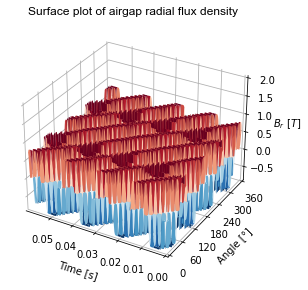

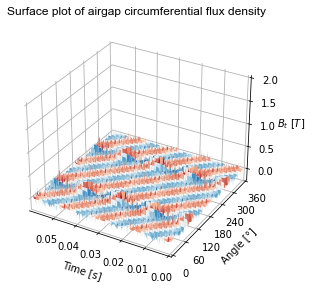

In [21]:
out.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False,z_max=2)


In [22]:
# Simu2 - Transfer Definition of the enforced output of the electrical module

simu2 = simu.copy()
simu2.mag.Kmesh_fineness = 4
simu2.force.is_agsf_transfer=True
simu2.force.max_wavenumber_transfer = 96

# Definition of the open-circuit simulation
simu2.input.OP.set_Id_Iq(Id=0,Iq=0)


In [23]:
out2 = simu2.run()

[12:08:47] Starting running simulation Toyota_Prius_AGSF_Transfer (machine=Toyota_Prius)
[12:08:47] Starting Magnetic module
[12:08:48] Solving time step 9 / 32 in FEMM
[12:08:48] Solving time step 1 / 32 in FEMM
[12:08:48] Solving time step 13 / 32 in FEMM
[12:08:49] Solving time step 17 / 32 in FEMM
[12:08:49] Solving time step 21 / 32 in FEMM
[12:08:49] Solving time step 29 / 32 in FEMM
[12:08:49] Solving time step 25 / 32 in FEMM
[12:08:50] Solving time step 5 / 32 in FEMM
[12:09:52] Solving time step 10 / 32 in FEMM
[12:09:53] Solving time step 26 / 32 in FEMM
[12:09:58] Solving time step 2 / 32 in FEMM
[12:09:59] Solving time step 18 / 32 in FEMM
[12:10:04] Solving time step 22 / 32 in FEMM
[12:10:04] Solving time step 6 / 32 in FEMM
[12:10:05] Solving time step 14 / 32 in FEMM
[12:10:05] Solving time step 30 / 32 in FEMM
[12:10:12] Solving time step 11 / 32 in FEMM
[12:10:13] Solving time step 27 / 32 in FEMM
[12:10:13] Solving time step 19 / 32 in FEMM
[12:10:13] Solving time s

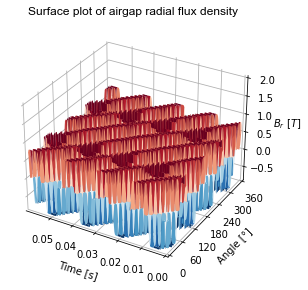

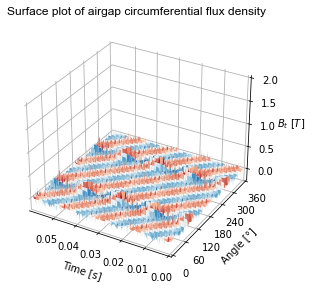

In [24]:
out2.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False,z_max=2)


## AGSF transfer law의 검증

공극은 회전자 외측 반경(Rrbo)과 고정자 내측 반경(Rsbo) 사이의 영역입니다.
(공극의 시작(K=0%) ~ 끝(K=100%)로 정의)
 AGSF를 계산하기 위한 일반적으로 MST의 계산은 공극 중앙(K=50%)에서 이뤄집니다. 

 아래 실습에서는 아래 두가지 방법으로 각각 구한 Force를 비교합니다.

- 원하는 반경(K)에서 직접 추출
- 고정된 K=50%에서 AGSF을 추출하고 Transfer Law에 의해서 다른 K값으로 환산



In [25]:
K = [90]
mm=0.001
Rsbo = 80.95*mm
Rrbo = 80.2*mm

Nk = len(K)

simu_list = list()  # direct calculation
simu_list2 = list() # Transfer

out_list = list()
out_list2 = list()

AGSF_list = list() # direct calculation
AGSF_list2 = list() # Transfer

legend_list = list()
legend_list2 = list()

for ik in range(Nk):
    k = K[ik]
    Rag = (Rsbo - Rrbo) * k / 100 + Rrbo
    
    #K=90%에서 직접 추출
    simu_list.append(simu.copy())
    simu_list[ik].mag.Rag_enforced = Rag
    out_list.append(simu_list[ik].run())
    legend_list.append(str(k) + "%")
    AGSF_list.append(out_list[ik].force.AGSF)
    
    #K=50% -> 90%로 AGSF Transfer 적용
    simu_list2.append(simu2.copy())
    simu_list2[ik].force.Rsbo_enforced_transfer = Rag
    out_list2.append(simu_list2[ik].run())
    legend_list2.append(str(k) + "%")
    AGSF_list2.append(out_list2[ik].force.AGSF)
    



[12:11:09] Starting running simulation Toyota_Prius_AGSF_Transfer (machine=Toyota_Prius)
[12:11:09] Starting Magnetic module
[12:11:10] Solving time step 9 / 32 in FEMM
[12:11:10] Solving time step 5 / 32 in FEMM
[12:11:10] Solving time step 1 / 32 in FEMM
[12:11:10] Solving time step 13 / 32 in FEMM
[12:11:11] Solving time step 17 / 32 in FEMM
[12:11:11] Solving time step 21 / 32 in FEMM
[12:11:11] Solving time step 29 / 32 in FEMM
[12:11:12] Solving time step 25 / 32 in FEMM
[12:12:15] Solving time step 10 / 32 in FEMM
[12:12:15] Solving time step 26 / 32 in FEMM
[12:12:18] Solving time step 2 / 32 in FEMM
[12:12:24] Solving time step 18 / 32 in FEMM
[12:12:24] Solving time step 22 / 32 in FEMM
[12:12:24] Solving time step 14 / 32 in FEMM
[12:12:24] Solving time step 30 / 32 in FEMM
[12:12:24] Solving time step 6 / 32 in FEMM
[12:12:32] Solving time step 27 / 32 in FEMM
[12:12:32] Solving time step 3 / 32 in FEMM
[12:12:32] Solving time step 11 / 32 in FEMM
[12:12:42] Solving time st

결과를 플롯하여 AGSF Transfer law의 유효성을 확인할 수 있습니다. 

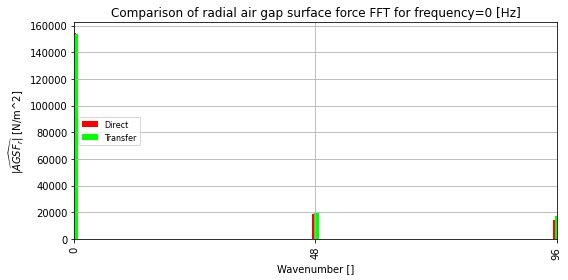

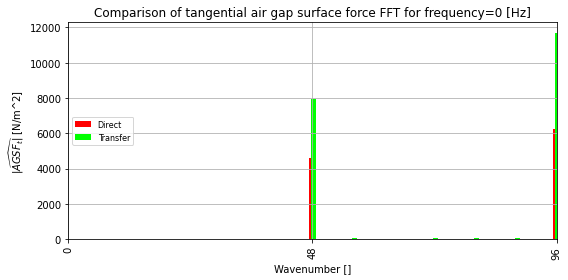

In [51]:
from pyleecan.Functions.Plot import dict_2D
ik = 0
out_list[ik].force.AGSF.plot_2D_Data(
    "wavenumber=[0,96]",
    "freqs=0", #equivalent to time=0 in this case
    data_list=[AGSF_list2[ik]],
    legend_list=["Direct", "Transfer"],
    is_show_fig=True,
    **dict_2D
)

## k=99%에서 정확도
메쉬의 성김에 따른 시뮬레이션을 비교합니다.

-거친 메쉬를 사용한 시뮬레이션
-미세한 메쉬를 사용한 시뮬레이션.

비교된 출력은 에어 갭 반경의 99%에서 AGSF입니다.


In [27]:
# k=99% 정의
Rs = (Rsbo - Rrbo) * 99 / 100 + Rrbo 

simu2 = simu.copy()
simu2.force.is_agsf_transfer = True
simu2.force.Rsbo_enforced_transfer = Rs
simu2.force.max_wavenumber_transfer = 100

out2 = simu2.run()

# Enforced Rag for ref
simu.mag.Rag_enforced = Rs
out = simu.run()

# Simu with low finesness
simu3 = simu.copy()
simu3.mag.Kmesh_fineness = 1
out3 = simu3.run()

[12:15:36] Starting running simulation Toyota_Prius_AGSF_Transfer (machine=Toyota_Prius)
[12:15:36] Starting Magnetic module
[12:15:37] Solving time step 9 / 32 in FEMM
[12:15:37] Solving time step 5 / 32 in FEMM
[12:15:37] Solving time step 13 / 32 in FEMM
[12:15:37] Solving time step 25 / 32 in FEMM
[12:15:38] Solving time step 21 / 32 in FEMM
[12:15:38] Solving time step 17 / 32 in FEMM
[12:15:38] Solving time step 1 / 32 in FEMM
[12:15:39] Solving time step 29 / 32 in FEMM
[12:16:38] Solving time step 26 / 32 in FEMM
[12:16:38] Solving time step 10 / 32 in FEMM
[12:16:46] Solving time step 2 / 32 in FEMM
[12:16:47] Solving time step 18 / 32 in FEMM
[12:16:53] Solving time step 6 / 32 in FEMM
[12:16:53] Solving time step 22 / 32 in FEMM
[12:16:53] Solving time step 30 / 32 in FEMM
[12:16:56] Solving time step 14 / 32 in FEMM
[12:16:59] Solving time step 27 / 32 in FEMM
[12:17:01] Solving time step 11 / 32 in FEMM
[12:17:06] Solving time step 3 / 32 in FEMM
[12:17:06] Solving time st

접선 방향 값에 대해서 수치해석적인 정확도의 이점을 확인할수 있습니다. 거친 메쉬에서 전달 법칙으로 계산된 AGSF가 미세 메쉬와 관련하여 대부분의 파수에서 더 정확합니다.

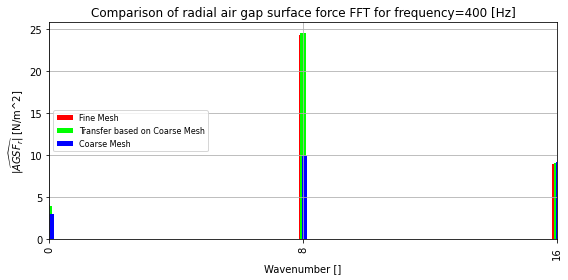

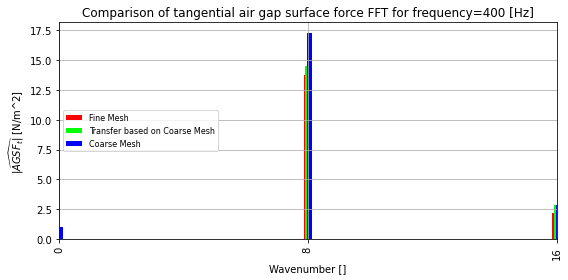

In [52]:
AGSF_list = list()
AGSF_list.append(out2.force.AGSF)
AGSF_list.append(out3.force.AGSF)
legend_list = ["Fine Mesh", "Transfer based on Coarse Mesh", "Coarse Mesh"]

out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,22]",
    "freqs=400", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    **dict_2D
)

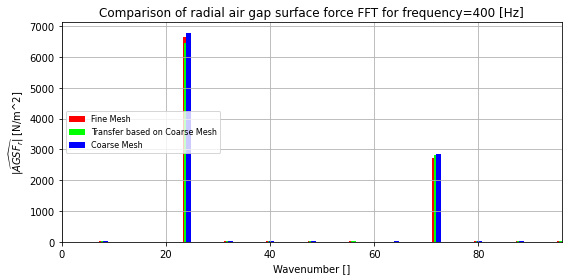

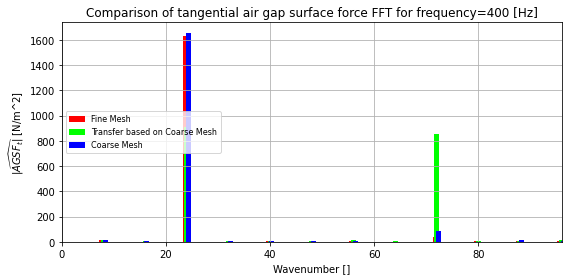

In [53]:
out.force.AGSF.plot_2D_Data(
    "wavenumber=[0,100]",
    "freqs=400", #equivalent to time=0 in this case
    data_list=AGSF_list,
    legend_list=legend_list,
    is_show_fig=True,
    is_auto_ticks = False,
    **dict_2D
)

 [1] PILE, Raphaël, LE BESNERAIS, Jean, PARENT, Guillaume, et al. Analytical study of air-gap surface force–application to electrical machines. Open Physics, 2020, vol. 18, no 1, p. 658-673